# Surface type distinction to get melt factor depending on snow age 

-> **Figures for the paper to show how the sfc type distinction model works!!!**
(We take HEF because that has also sufficient MB profiles and seasonal data to compare the model types to!)

-> creates the plot for the Appendix: 

- fig_A1_sfc_type_distinction_hef_merged.pdf
    - two single plots are manually merged: 
        - `fig_A1_sfc_type_distinction_hef_part1.pdf`
        - `fig_A1_sfc_type_distinction_hef_part2.pdf`

----

**the surface type distinction model is included with a bucket system together with a degree-day factor (melt_f) that varies with age** inside of `TIModel_Sfc_Type`:
- there are two options included at the moment:
    - `melt_f_update=annual`
        - If annual, then it uses 1 snow
            and 5 firn buckets with yearly melt factor updates.
    - `melt_f_update=monthly`: -> **we use this option for the manuscript**
        -  If monthly, each month the snow is ageing over 6 years (i.e., 72 months -> 72 buckets).
    - the ice bucket is thought as an "infinite" bucket (because we do not know the ice thickness at this model stage)
    - Melt factors are interpolated either:
        - linearly inbetween the buckets.
        - or using a negativ exponential change assumption with an e-folding change assumption of e.g. 0.5 or 1 year
- default is to use a **spinup** of 6 years. So to compute the specific mass balance between 2000 and 2020, with `spinup=True`, the annual mb is computed since 1994 where at first everything is ice, and then it accumulates over the next years, so that in 2000 there is something in each bucket ...
    - if we start in 1979 (start of W5E5), we neglect the spinup because we don't have climate data before 1979

- the ratio of snow melt factor to ice melt factor is set to 0.5 (as in GloGEM) but it can be changed via `melt_f_ratio_snow_to_ice`
    - if we set `melt_f_ratio_snow_to_ice=1` the melt factor is equal for all buckets, hence the results are equal to no surface type distinction (as in `TIModel`)
- `get_annual_mb` and `get_monthly_mb` work as in PastMassBalance, however they only accept the height array that corresponds to the inversion height (so no mass-balance elevation feedback can be included at the moment!)
    - that means the given mass-balance ist the mass-balance over the inversion heights (before doing the inversion and so on)
- the buckets are automatically updated when using `get_annual_mb` or `get_monthly_mb` via the `TIModel_Sfc_Type.pd_bucket` dataframe 
- to make sure that we do not compute mass-balance twice and to always have a spin-up of 6 years, we save the mass balance under 
    - `get_annual_mb.pd_mb_annual`: for each year
        - when using `get_monthly_mb` for several years, after computing the December month, the `pd_mb_annual` dataframe is updated
    - `get_annual_mb.pd_mb_monthly`: for each month 
        - note that this stays empty if we only use get_annual_mb with annual melt_f_update

In [2]:
# path where OGGM gdirs are: is created in data_creating_scripts
working_dir = '../oggm_run_gdir_folder/node_folder'
# figure path
fig_path = '../figures'
# data path -> data created from 00_data_creating scripts
data_path = '../01_data'

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import ast

import matplotlib.pyplot as plt
import matplotlib

from numpy.testing import assert_allclose
import statsmodels as stats
import scipy

import scipy.stats as stats
from IPython.core.pylabtools import figsize
import os

# OGGM modules
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.utils import date_to_floatyear
from oggm.shop import gcm_climate
from oggm.core import massbalance, flowline, climate

# import the MBsandbox modules
from MBsandbox.mbmod_daily_oneflowline import (process_w5e5_data, TIModel,
                                               BASENAMES, MultipleFlowlineMassBalance_TIModel,
                                               TIModel_Sfc_Type)

from MBsandbox.help_func import (minimize_bias_geodetic, optimize_std_quot_brentq_geod,
                                 minimize_winter_mb_brentq_geod_via_pf,
                                 calibrate_to_geodetic_bias_quot_std_different_temp_bias)
from MBsandbox.help_func import calibrate_to_geodetic_bias_winter_mb

import logging
log = logging.getLogger(__name__)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

cfg.initialize() #logging_level='WARNING'
cfg.PARAMS['use_multiprocessing'] = False
cfg.PARAMS['continue_on_error'] = False
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-sfc-type', reset=False)

# use Huss flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')


cfg.PARAMS['hydro_month_nh']=1
# We take HEF because that has also sufficient MB profiles and seasonal
# data to compare the model types
df = ['RGI60-11.00897']

gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=10,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
gdir = gdirs[0]

2023-01-13 10:25:54: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-01-13 10:25:54: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-01-13 10:25:54: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-01-13 10:25:54: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2023-01-13 10:25:54: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-01-13 10:25:54: oggm.utils: /home/data/download/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.00.tar verified successfully.


In [4]:
# get the geodetic data for calibration
pd_geodetic = utils.get_geodetic_mb_dataframe()
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']
mb_geodetic = pd_geodetic.loc[df].dmdtda.values * 1000
years = np.arange(2000, 2020, 1)

2023-01-13 10:25:55: oggm.utils: /home/data/download/cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide_filled.hdf verified successfully.


In [5]:
# this is the resolution of the precipitation and temperature 
temporal_resol = 'daily'
baseline_climate = 'W5E5' 

mb_type = 'mb_real_daily'
grad_type='var_an_cycle'
pf = 3.46 # this estimate comes from calibration option C5 for HEF (prcp. fac dependent on winter prcp., 
# see ./analysis_notebooks/updated_2022_10_notebooks/fig_3_..._performance_validation.ipynb
# there do : xr_params_stats_w_for_calib_option_e.sel(rgi_id='RGI60-11.00897').pf_opt

In [6]:
process_w5e5_data(gdir, temporal_resol=temporal_resol,
                  climate_type=baseline_climate)
process_w5e5_data(gdir, temporal_resol='daily',
                  climate_type=baseline_climate)
h, w = gdir.get_inversion_flowline_hw()


2023-01-13 10:25:55: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_w5e5_data
2023-01-13 10:25:55: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc to /tmp/OGGM/OGGM-sfc-type/cache/cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc...
2023-01-13 10:25:57: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc
2023-01-13 10:25:57: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc to /tmp/OGGM/OGGM-sfc-type/cache/cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc...
2023-01-13 10:25:59: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.

In [9]:
fls = gdir.read_pickle('inversion_flowlines')
melt_f = 200  # this is just the starting point, and the actual melt_f is found by matching to the geodetic observations! 
# just for comparison: instance with no surface type distinction 
mb_mod_no_sfc_type = TIModel(gdir, melt_f, mb_type=mb_type,grad_type=grad_type,
                                     prcp_fac=pf, baseline_climate=baseline_climate)

melt_f_opt_no_sfc_type = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                      xtol=0.01, args=(mb_mod_no_sfc_type,
                                                       mb_geodetic,
                                                       h, w, pf, False,
                                                       years,
                                                       False, True  # do spinup before
                                                       ), disp=True)
mb_mod_no_sfc_type.melt_f = melt_f_opt_no_sfc_type
spec_no_sfc_type = mb_mod_no_sfc_type.get_specific_mb(year=years, fls=fls)

# with normal spinup for 5 years
mb_mod_monthly_0_5_m = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,grad_type=grad_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          baseline_climate=baseline_climate)
melt_f_opt_0_5_m = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_monthly_0_5_m.melt_f = melt_f_opt_0_5_m
spec_0_5_m = mb_mod_monthly_0_5_m.get_specific_mb(year=years, fls=fls) #, spinup=True)
print(melt_f_opt_0_5_m)

400.1155141183498


Monthly MB is saved in the `TIModel_Sfc_Type` instance:

In [11]:
# the first 6 years are the spinup
# 
mb_mod_monthly_0_5_m.pd_mb_monthly.iloc[::10]

,1994.000000,1994.083333,1994.166667,1994.250000,1994.333333,1994.416667,1994.500000,1994.583333,1994.666667,1994.750000,...,2019.166667,2019.250000,2019.333333,2019.416667,2019.500000,2019.583333,2019.666667,2019.750000,2019.833333,2019.916667
distance_along_flowline,,,,,,,,,,,,,,,,,,,,,
0.0,1.002029e-07,2.319840e-08,3.630857e-08,6.938164e-08,1.287839e-07,5.098040e-08,-4.022267e-08,2.623037e-09,2.188006e-07,3.399363e-08,...,8.447470e-08,1.365462e-07,1.465296e-07,-2.483320e-08,-6.359908e-08,7.156948e-08,1.087145e-07,9.940119e-08,2.497283e-07,7.617932e-08
1000.0,1.002029e-07,2.319840e-08,3.630857e-08,6.938164e-08,1.267640e-07,-5.836440e-08,-3.661537e-07,-4.931943e-07,1.401054e-07,2.198398e-08,...,8.447470e-08,1.365462e-07,1.465296e-07,-1.287063e-07,-3.067468e-07,-2.638003e-07,3.183089e-08,7.773564e-08,2.497283e-07,7.617932e-08
2000.0,1.002029e-07,2.319840e-08,3.630857e-08,6.803589e-08,1.079226e-07,-1.447668e-07,-7.497701e-07,-7.672031e-07,1.779616e-08,8.228192e-09,...,8.447470e-08,1.365462e-07,1.465296e-07,-2.654936e-07,-4.740607e-07,-7.031058e-07,-1.316468e-07,1.993131e-08,2.497283e-07,7.617932e-08
3000.0,1.002029e-07,2.319840e-08,3.630857e-08,6.598837e-08,8.645276e-08,-1.951945e-07,-9.484799e-07,-8.999717e-07,-1.081059e-07,-1.985466e-08,...,8.447470e-08,1.365462e-07,1.457329e-07,-3.413288e-07,-6.340888e-07,-9.150316e-07,-2.323676e-07,-4.053869e-08,2.497283e-07,7.617932e-08
4000.0,1.002029e-07,2.319840e-08,3.481850e-08,6.271424e-08,5.838863e-08,-2.408181e-07,-1.123615e-06,-1.013806e-06,-2.359720e-07,-5.435469e-08,...,8.447470e-08,1.365462e-07,1.417539e-07,-4.013455e-07,-8.320434e-07,-1.022541e-06,-3.171493e-07,-1.306909e-07,2.479028e-07,7.617932e-08
5000.0,1.002029e-07,2.319840e-08,3.037280e-08,5.701118e-08,6.645879e-09,-3.815188e-07,-1.297669e-06,-1.162732e-06,-3.907966e-07,-1.030262e-07,...,8.447470e-08,1.362126e-07,1.278756e-07,-4.766460e-07,-1.104063e-06,-1.162738e-06,-4.497882e-07,-2.527795e-07,2.343873e-07,6.953673e-08


Buckets when using monthly melt_f_update:

In [13]:
# this is the output after the update (and before the next month)
# hence: the "youngest" bucket 0 is 0 
mb_mod_monthly_0_5_m.pd_bucket[::5]

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,delta_kg/m2
distance_along_flowline,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,180.179323,590.657406,235.103690,257.131474,169.276145,0.0,0.0,137.411706,322.959143,...,194.254162,130.857604,445.857171,360.566282,252.828211,185.120081,218.204346,133.964111,230.874369,NaN
500.0,0.0,180.179323,590.657406,230.317292,167.072463,0.000000,0.0,0.0,0.000000,0.000000,...,182.082804,107.027635,305.205641,157.722057,108.043057,185.120081,218.204346,133.964111,230.874369,NaN
1000.0,0.0,180.179323,590.657406,183.860337,75.286426,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
1500.0,0.0,180.179323,590.657406,115.828047,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2000.0,0.0,180.179323,590.657406,47.141545,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2500.0,0.0,180.179323,590.657406,9.444982,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
3000.0,0.0,180.179323,590.657406,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
3500.0,0.0,180.179323,588.995880,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
4000.0,0.0,180.179323,586.339759,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


**use a non-linear neg. exp change of the degree-day factor from snow, over firn to ice**

In [15]:
### monthly melt_f_update
# with normal spinup for 6 years tau = 0.5
mb_mod_monthly_0_5_m_neg_exp = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type, grad_type=grad_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 0.5, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_m_neg_exp = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m_neg_exp,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)

mb_mod_monthly_0_5_m_neg_exp.melt_f = melt_f_opt_0_5_m_neg_exp
spec_0_5_m_neg_exp = mb_mod_monthly_0_5_m_neg_exp.get_specific_mb(year=years, fls=fls) #, spinup=True)
print('monthly melt_f_opt:')
print(melt_f_opt_0_5_m_neg_exp)

# with normal spinup for 6 years tau = 1yr
mb_mod_monthly_0_5_m_neg_exp_tau1yr = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,grad_type=grad_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 1, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_m_neg_exp_tau1yr = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m_neg_exp_tau1yr,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)

mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f = melt_f_opt_0_5_m_neg_exp_tau1yr
spec_0_5_m_neg_exp_tau1yr = mb_mod_monthly_0_5_m_neg_exp_tau1yr.get_specific_mb(year=years, fls=fls) #, spinup=True)
print(melt_f_opt_0_5_m_neg_exp_tau1yr)

assert_allclose(spec_0_5_m_neg_exp.mean(), spec_0_5_m_neg_exp_tau1yr.mean(),rtol=1e-4)



monthly melt_f_opt:
350.8317958996194
368.43476842839067


We also implemented an annual instead of monthly degree-day factor update, it is not used in the manuscript, but we compute it
below as well to compare later the differences (not shown in the manuscript) 

In [16]:
### do the same with annual update just as comparison
# just for comparison: instance with no surface type distinction 
mb_mod_annual_1_a = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,grad_type=grad_type,
                                          melt_f_ratio_snow_to_ice=1, prcp_fac=pf,
                                          melt_f_update='annual',
                                          baseline_climate=baseline_climate)
melt_f_opt_1_a = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                             xtol=0.01, args=(mb_mod_annual_1_a,
                                                              mb_geodetic,
                                                              h, w, pf, False,
                                                              years,
                                                              False, True  # do spinup before
                                                              ), disp=True)
mb_mod_annual_1_a.melt_f = melt_f_opt_1_a

spec_1_a = mb_mod_annual_1_a.get_specific_mb(year=years, fls=fls) #, spinup=True)


# get an instance of a TIModel_Sfc_Type with annual degree-day factor update of the melt factor 
# -> just as a comparison (not used in the manuscript)
mb_mod_annual_0_5_a = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,grad_type=grad_type,
                                  melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                    melt_f_update='annual',
                                  baseline_climate=baseline_climate
                                    )
melt_f_opt_0_5_a = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                      xtol=0.01, args=(mb_mod_annual_0_5_a,
                                                       mb_geodetic,
                                                       h, w, pf, False,
                                                       years,
                                                       False, True  # do spinup before
                                                       ), disp=True)
mb_mod_annual_0_5_a.melt_f = melt_f_opt_0_5_a
spec_0_5_a = mb_mod_annual_0_5_a.get_specific_mb(year=years, fls=fls) #, spinup=True)




#### neg. exp non-linear change with annual update:
# annual melt_f_update:
# with normal spinup for 5 years
print('annual melt_f_opt:')

mb_mod_annual_0_5_a_neg_exp = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,grad_type=grad_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='annual',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 0.5, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_a_neg_exp = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_annual_0_5_a_neg_exp,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_annual_0_5_a_neg_exp.melt_f = melt_f_opt_0_5_a_neg_exp
spec_0_5_a_neg_exp = mb_mod_annual_0_5_a_neg_exp.get_specific_mb(year=years, fls=fls) #, spinup=True)

print(melt_f_opt_0_5_a_neg_exp)


# with normal spinup for 5 years
mb_mod_annual_0_5_a_neg_exp_tau1yr = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type,grad_type=grad_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='annual',
                                          melt_f_change = 'neg_exp', 
                                          tau_e_fold_yr = 1, # default
                                          baseline_climate=baseline_climate)

melt_f_opt_0_5_a_neg_exp_tau1yr = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_annual_0_5_a_neg_exp_tau1yr,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_annual_0_5_a_neg_exp_tau1yr.melt_f = melt_f_opt_0_5_a_neg_exp_tau1yr
spec_0_5_a_neg_exp_tau1yr = mb_mod_annual_0_5_a_neg_exp_tau1yr.get_specific_mb(year=years, fls=fls) #, spinup=True)
print(melt_f_opt_0_5_a_neg_exp_tau1yr)

assert_allclose(spec_0_5_a_neg_exp.mean(), spec_0_5_a_neg_exp_tau1yr.mean(),rtol=1e-4)


annual melt_f_opt:
408.4584063467273
409.54662761370713


**Get the MB profile data for all the options:**

In [17]:
for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    mb.get_specific_mb(year=years, fls=fls)

mb_grad_dict = {}
mb_annual_dict = {}
for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    mb_grad_dict_name = []
    mb_annual_dict_name = {}
    for y in years:
        mb_y = mb.pd_mb_annual[y]
        mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_y<0], y=mb_y[mb_y<0]) 
        mb_grad_dict_name.append(mb_gradient)
        mb_annual_dict_name[y] = mb_y
    mb_grad_dict[name] = np.array(mb_grad_dict_name)
    mb_annual_dict[name] = mb_annual_dict_name

    
mb_grad_dict_m = {}
mb_monthly_dict = {}
bucket = {}
k=1
for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    # need to reset otherwise I can't get the pd_buckets right!!!
    mb.reset_pd_mb_bucket()
    mb_grad_dict_name = []
    mb_monthly_dict_name = {}
    bucket_name = {}
    for y in years:
        for m in np.arange(1,13,1):
            floatyr = date_to_floatyear(y,m)
            #if name != '0_5_m':
            _, bucket_name[floatyr] = mb.get_monthly_mb(h, year=floatyr, bucket_output =True)
            mb_m = mb.pd_mb_monthly[floatyr]
            try:
                mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_m<0], y=mb_m[mb_m<0]) 
            except:
                mb_gradient = np.NaN
            mb_grad_dict_name.append(mb_gradient)
            mb_monthly_dict_name[floatyr] = mb_m
    mb_grad_dict_m[name] = np.array(mb_grad_dict_name)
    mb_monthly_dict[name] = mb_monthly_dict_name
    bucket[name] = bucket_name

**We estimate MB profiles for every month -> and save them as "winter" and "summer" MB profile. Make a plot to show how the MB profiles change over the months (only for the options that are used in the manuscript, i.e. no surface type distinction or monthly neg. exp or linear):**

(plot below not shown in the manuscript!)

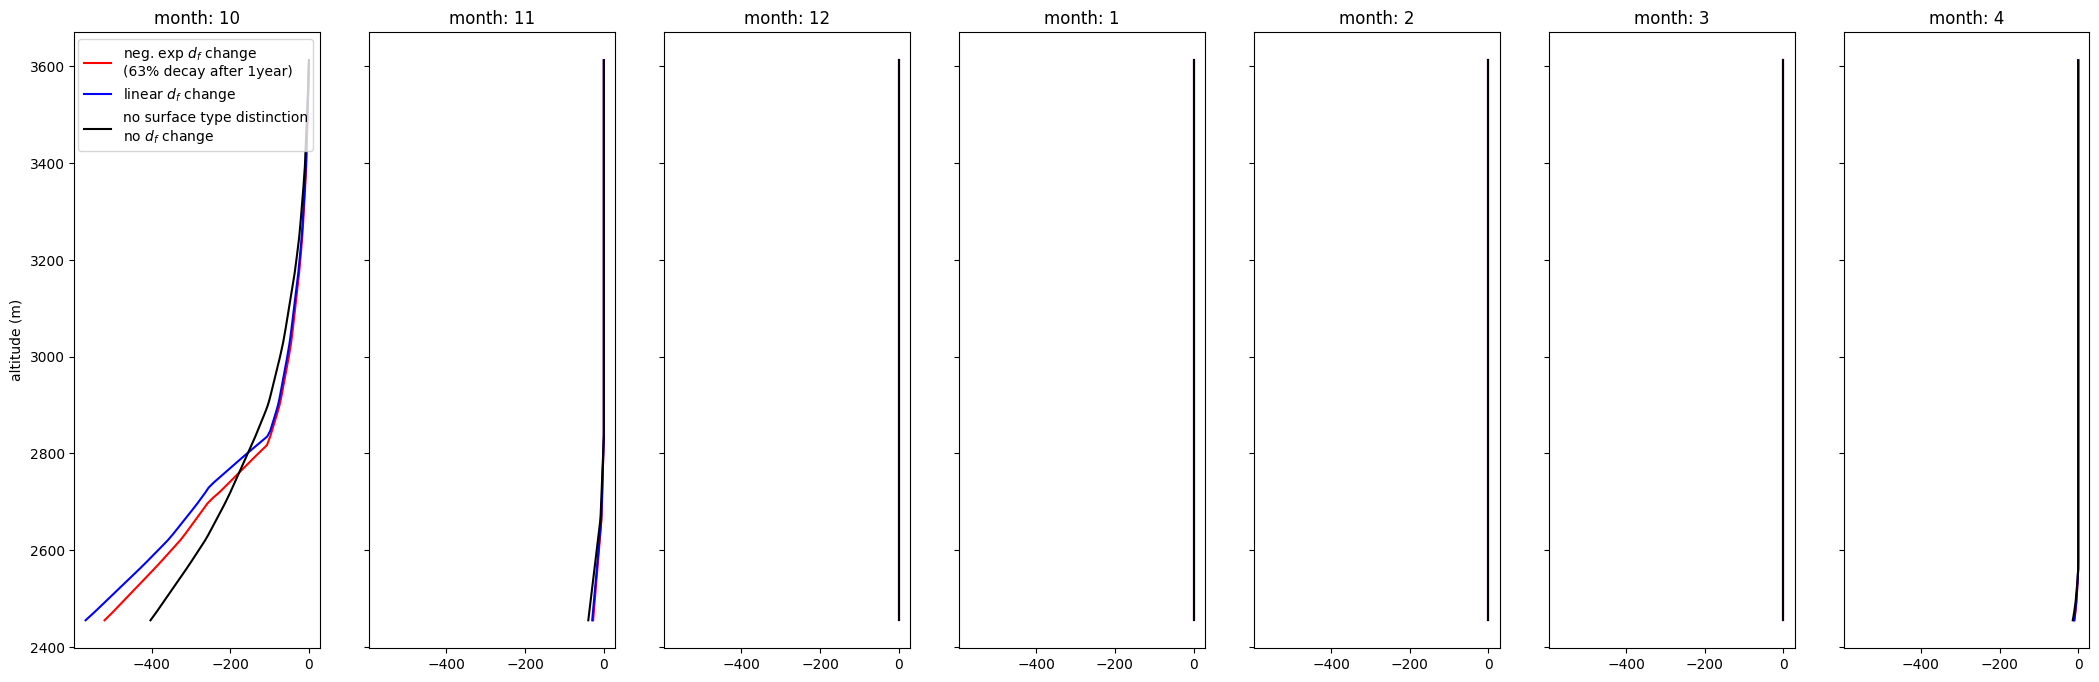

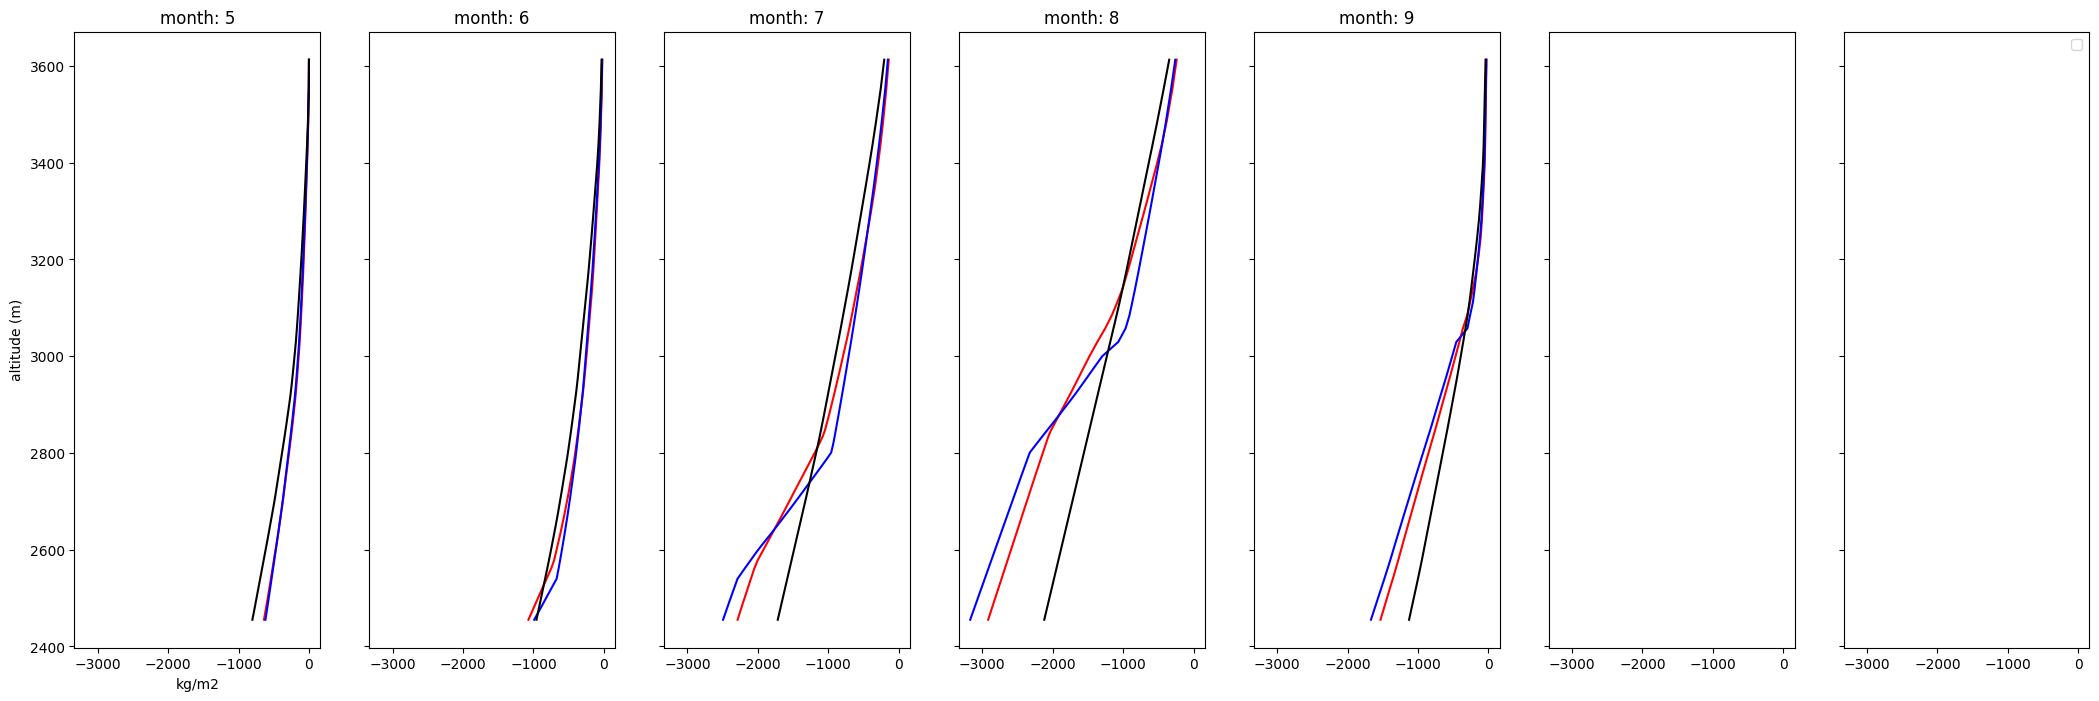

In [22]:
## also get winter / summer MB profiles
y0 = 1980 # 1979 does not work because it would need winter MB from 1978 !
m_winter_mb = [10,11,12,1,2,3,4]
m_summer_mb = [5,6,7,8,9]
yr_changes = True
m_start = 10
add_climate = True
ratio = 1
melt_m_10 = {}
melt_m_4 = {}
melt_m_5 = {}
mb_grad_winter = {}
mb_grad_summer = {}
mb_grad_winter_melt = {}
mb_grad_summer_melt = {}
label_dict = {'1_a': 'no surface type distinction\n'+ r'no $d_f$ change', '0_5_m':r'linear $d_f$ change',
              '0_5_m_neg_exp_tau1yr':r'neg. exp $d_f$ change'+'\n(63% decay after 1year)'}
color_dict = {'1_a': 'black', '0_5_m':'blue', '0_5_m_neg_exp_tau1yr':'red'}
fig_w, axs_w = plt.subplots(1,7, figsize=(26,8), sharey=True, sharex=True)
fig_s, axs_s = plt.subplots(1,7, figsize=(26,8), sharey=True, sharex=True)

for mb, name in zip([mb_mod_monthly_0_5_m_neg_exp_tau1yr, mb_mod_monthly_0_5_m_neg_exp, mb_mod_monthly_0_5_m, mb_mod_annual_0_5_a_neg_exp,
                     mb_mod_annual_0_5_a_neg_exp_tau1yr, mb_mod_annual_0_5_a, mb_mod_annual_1_a],
                    ['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp','0_5_a', '1_a']):
    mb.reset_pd_mb_bucket()
    _ = mb.get_specific_mb(h, widths=w, year=np.arange(1979,2020,1))

    pd_winter_mb = pd.DataFrame(index=h, columns=np.arange(y0,2020,1))
    pd_summer_mb = pd.DataFrame(index=h, columns=np.arange(y0,2020,1))
    pd_winter_melt = pd.DataFrame(index=h, columns=np.arange(y0,2020,1))
    pd_summer_melt = pd.DataFrame(index=h, columns=np.arange(y0,2020,1))
    for year in np.arange(y0, 2020,1):
        mbs_winter = 0
        mbs_summer= 0
        prcp_sol_winter =0
        prcp_sol_summer = 0
        
        for j,m in enumerate(m_winter_mb):
            if (m in np.arange(m_start, 13, 1)) and (yr_changes):
                floatyr = utils.date_to_floatyear(year-1, m)
            else:
                floatyr = utils.date_to_floatyear(year, m)
            out = mb.get_monthly_mb(h, year=floatyr, add_climate=True)
            out, t, tfm, prcp, prcp_sol = out
            mbs_winter += out * ratio
            prcp_sol_winter += prcp_sol *ratio
            if (year== 2008 and m>=10) or (year == 2009 and m<10):
                try:
                    if m == 10 and year == 2008:
                        melt_m_10[name] = out*mb.SEC_IN_MONTH * mb.rho-prcp_sol
                    elif m == 4 and year == 2009:
                        melt_m_4[name] = out*mb.SEC_IN_MONTH * mb.rho-prcp_sol
                    axs_w[j].plot(out*mb.SEC_IN_MONTH * mb.rho-prcp_sol, h,
                             color = color_dict[name], label=label_dict[name])
                    if m==10:
                        plt.legend()
                    axs_w[j].set_title(f'month: {m}')
                except:
                    pass
            #mbs_winter += mb_winter_m
        for jj, m in enumerate(m_summer_mb):
            floatyr = utils.date_to_floatyear(year, m)
            out = mb.get_monthly_mb(h, year=floatyr, add_climate=True)
            out, t, tfm, prcp, prcp_sol = out
            mbs_summer += out * ratio
            prcp_sol_summer += prcp_sol *ratio
            if (year== 2008 and m>=10) or (year == 2009 and m<10):
                try:
                    if m == 5 and year == 2009:
                            melt_m_5[name] = out*mb.SEC_IN_MONTH * mb.rho-prcp_sol
                except:
                    pass
            if year == 2009:
                try:
                    
                    axs_s[jj].plot(out*mb.SEC_IN_MONTH * mb.rho-prcp_sol, h,
                             color = color_dict[name], label=label_dict[name])
                        
                    axs_s[jj].set_title(f'month: {m}')
                except:
                    pass
            
            
        mbs_winter = mbs_winter * mb.SEC_IN_MONTH * mb.rho
        mbs_summer = mbs_summer * mb.SEC_IN_MONTH * mb.rho

        pd_winter_mb.loc[h, year] = mbs_winter
        pd_summer_mb.loc[h, year] = mbs_summer

        pd_winter_melt.loc[h, year] = mbs_winter-prcp_sol_winter
        pd_summer_melt.loc[h, year] = mbs_summer-prcp_sol_summer
        
    mb_grad_winter[name] = pd_winter_mb.mean(axis=1).values, pd_winter_mb.mean(axis=1).index
    mb_grad_summer[name] = pd_summer_mb.mean(axis=1).values, pd_summer_mb.mean(axis=1).index
    
    mb_grad_winter_melt[name] = pd_winter_melt.mean(axis=1).values, pd_winter_melt.mean(axis=1).index
    mb_grad_summer_melt[name] = pd_summer_melt.mean(axis=1).values, pd_summer_melt.mean(axis=1).index
    
axs_s[0].set_ylabel('altitude (m)')
axs_w[0].set_ylabel('altitude (m)')
axs_s[0].set_xlabel('kg/m2')
axs_w[0].legend()

**Now the actual Figure A1 for the manuscript Appendix**:

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
           dtype='int64')
3031.7976372458343
3031.7976372458343
3031.7976372458343


<Figure size 2600x800 with 0 Axes>

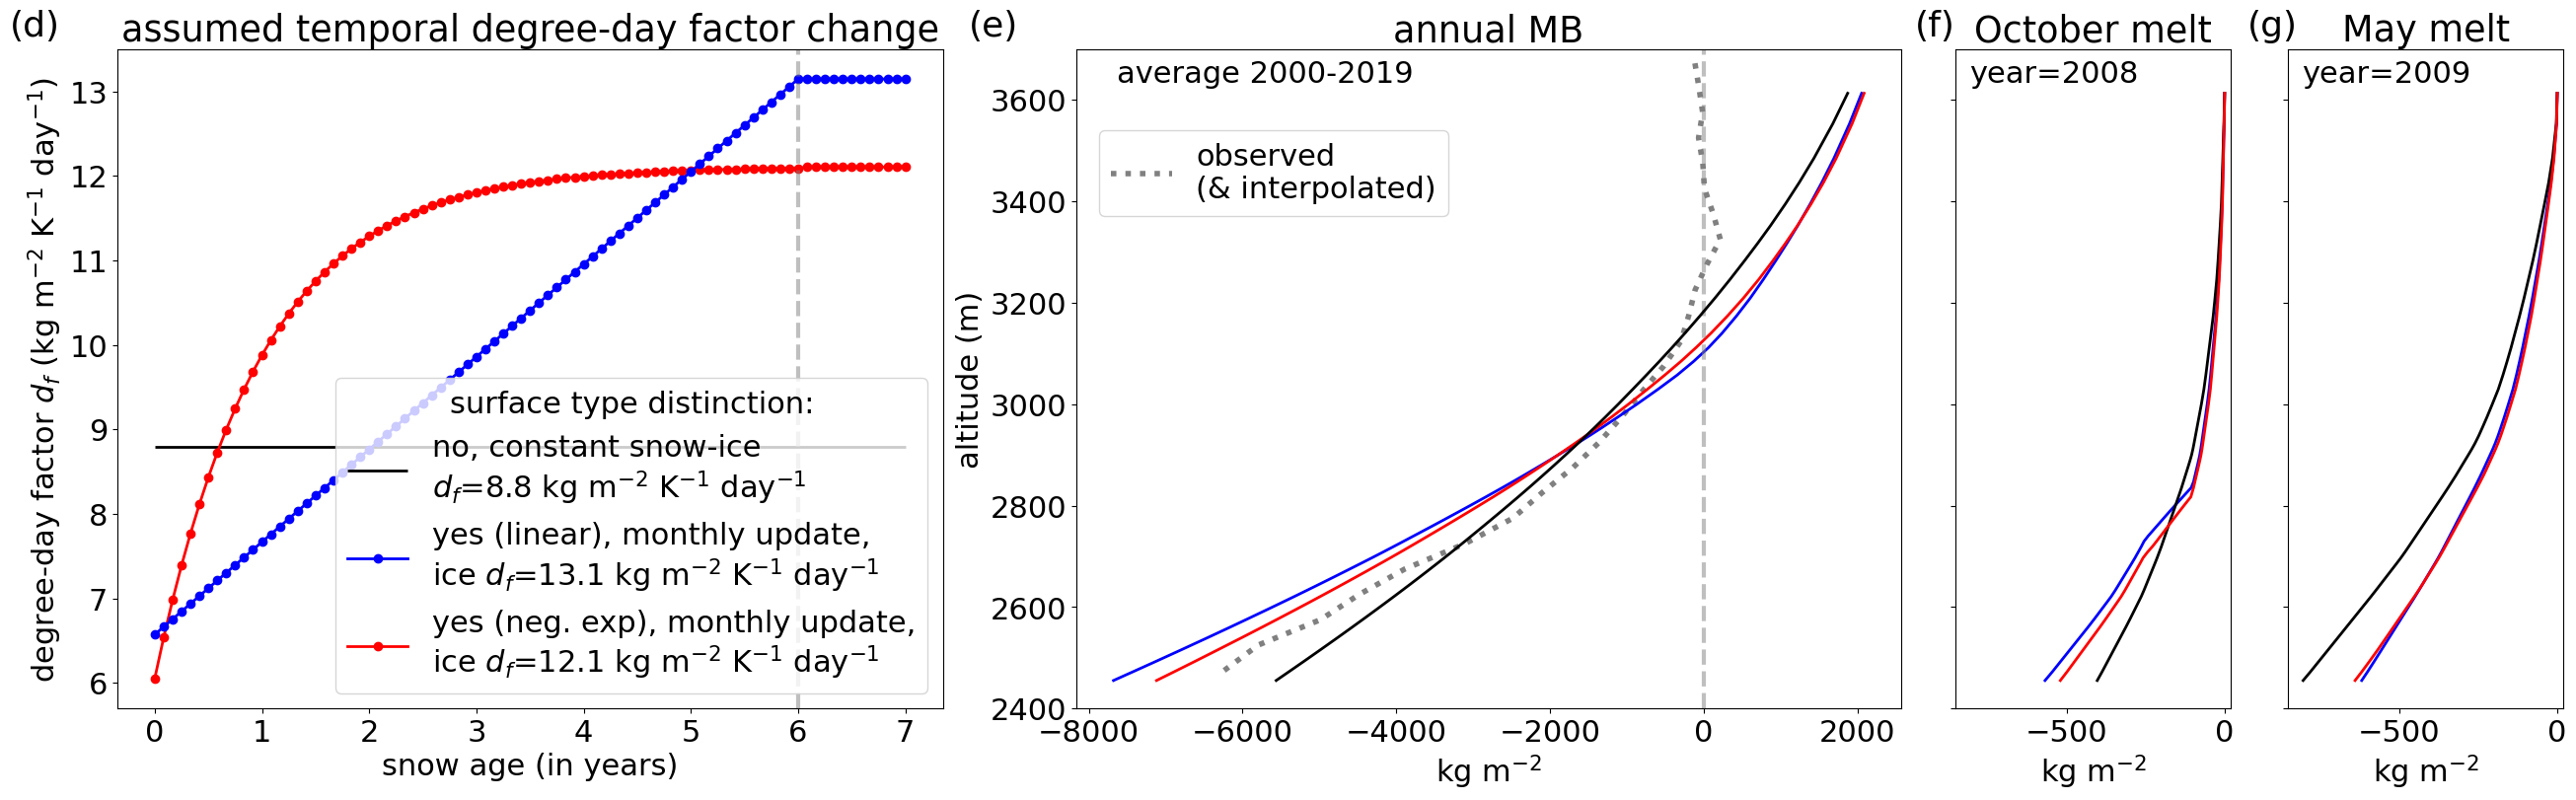

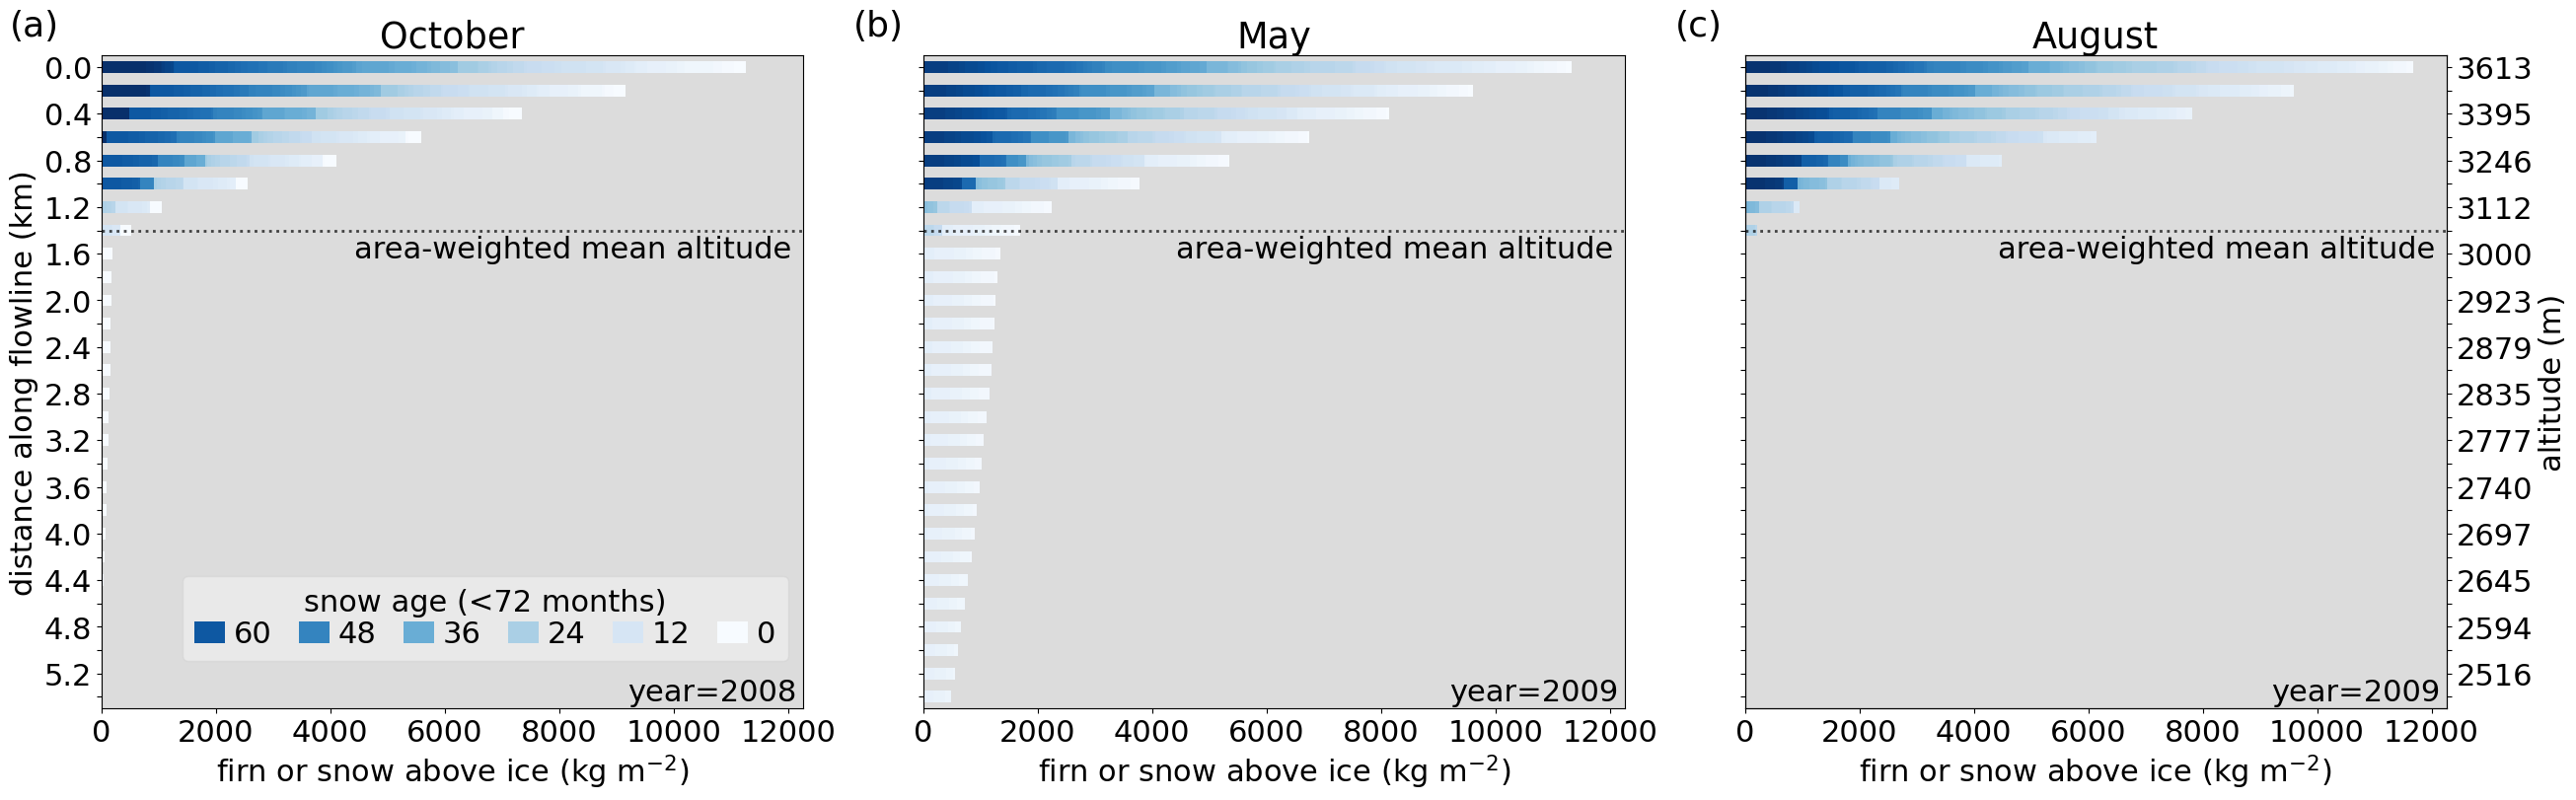

In [24]:
lw=2
# need to convert from monthly melt_f to daily melt_f (SI units)
fac_per_month_to_per_day = 365.25/12

fac = cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density']
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(26, 8))
fig, axs = plt.subplots(1, 4, gridspec_kw={'width_ratios': [3, 3, 1,1]}, figsize=(26, 8),
                       constrained_layout=True)
lw=2

#plt.subplot(121)
ax = axs[0] #plt.gca()
ax.text(-0.13,1.02,'(d)', transform=ax.transAxes, fontsize=26)
ax.hlines(xmin=0, xmax=7, y=mb_mod_annual_1_a.melt_f/fac_per_month_to_per_day,lw=2,
          color='black', label='no, constant snow-ice\n'+r'$d_f$'+'={:1.1f}'.format(melt_f_opt_1_a/fac_per_month_to_per_day)+' kg m$^{-2}$ K$^{-1}$ day$^{-1}$')#, ax=ax)


########
meltis = []
for _,m in mb_mod_monthly_0_5_m_neg_exp.melt_f_buckets.items():
    meltis.append(m)
for m in np.arange(0,12):
    #meltis.append(mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f)
    meltis.append(mb_mod_monthly_0_5_m_neg_exp.melt_f)

meltis_1yr = []
#for _,m in mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f_buckets.items():
for _,m in mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f_buckets.items():
    meltis_1yr.append(m)
# also add one year of ic melt_f s
for m in np.arange(0,12):
    #meltis.append(mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f)
    meltis_1yr.append(mb_mod_monthly_0_5_m_neg_exp_tau1yr.melt_f)  
    
ax.plot(np.arange(0,7.01,1/12), np.array(meltis_1yr)/fac_per_month_to_per_day, 'o-', color='red',lw=2,
         label='yes (neg. exp), monthly update,\nice '+r'$d_f$'+'={:1.1f}'.format(melt_f_opt_0_5_m_neg_exp_tau1yr/fac_per_month_to_per_day)+' kg m$^{-2}$ K$^{-1}$ day$^{-1}$') #  , tau=1yr)

########### linear

meltis = []
for _,m in mb_mod_monthly_0_5_m.melt_f_buckets.items():
    meltis.append(m)
for m in np.arange(0,12):
    meltis.append(mb_mod_monthly_0_5_m.melt_f)
ax.plot(np.arange(0,7.01,1/12), np.array(meltis)/fac_per_month_to_per_day, 'o-', color='blue',lw=2,
         label='yes (linear), monthly update,\nice '+r'$d_f$'+'={:1.1f}'.format(melt_f_opt_0_5_m/fac_per_month_to_per_day)+' kg m$^{-2}$ K$^{-1}$ day$^{-1}$') #, ax=ax)

ax.set_xticks(np.arange(0,7.1,1))

ax.set_xlabel('snow age (in years)')
ax.set_yticks([6,7,8,9,10,11,12,13])
ax.set_ylabel(r'degree-day factor $d_f$ (kg m$^{-2}$ K$^{-1}$ day$^{-1}$)')

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, title = 'surface type distinction:')
ax.set_title('assumed temporal degree-day factor change')

ax.axvline(6, color='gray', ls='--', alpha=0.5, lw=3)

ax = axs[1] #plt.gca()
ax.text(-0.13,1.02,'(e)', transform=ax.transAxes, fontsize=26)
ax.text(0.05,0.95, 'average 2000-2019', transform=ax.transAxes)
ref_profile = gdir.get_ref_mb_profile(input_filesuffix = '_daily_W5E5', constant_dh=True, obs_ratio_needed=0.6)
# take the same years as modelled (2000-2020)
ref_profile = ref_profile.loc[mb_annual_dict['1_a'].keys()]
# make sure that we have the right years
print(ref_profile.index)
obs_filtered = ref_profile.mean(axis=0)
ax.plot(obs_filtered.values, obs_filtered.index, ':', color='grey', label='observed\n(& interpolated)', lw=4,
       ) #, ax=ax)
ax.legend(bbox_to_anchor=(0.01,0.9), loc=2)

ax.plot(pd.DataFrame(mb_annual_dict['0_5_m']).mean(axis=1).values*fac, 
         h, color = 'blue', #ax=ax,
         lw=lw)

ax.plot(pd.DataFrame(mb_annual_dict['0_5_m_neg_exp_tau1yr']).mean(axis=1).values*fac,
         h, color = 'red', #ax=ax,
         lw=lw)
ax.axvline(0, color='gray', ls='--', alpha=0.5, lw=3)#, ax=ax)


ax.plot(pd.DataFrame(mb_annual_dict['1_a']).mean(axis=1).values*fac,
         h, color='black',
         lw=lw)#, ax=ax)

ax.set_xlabel(r'kg m$^{-2}$')
ax.set_ylabel('altitude (m)')
ax.set_ylim([2400, 3700])
ax.set_title('annual MB') #, fontsize=22)


ax = axs[3]
ax.text(-0.15,1.02,'(g)', transform=ax.transAxes, fontsize=26)
ax.plot(melt_m_5['0_5_m'], h, color = 'blue', lw=lw) #, ax=ax)
ax.plot(melt_m_5['1_a'], h, color = 'black', lw=lw) #, ax=ax)
ax.plot(melt_m_5['0_5_m_neg_exp_tau1yr'], h, color = 'red', lw=lw) #, ax=ax)
ax.set_xlabel(r'kg m$^{-2}$')
ax.set_ylim([2400, 3700])
ax.set_yticklabels([])
ax.set_title('May melt')#, fontsize=22)
ax.set_xlim([-850,20])
ax.text(0.05,0.95, 'year=2009', transform=ax.transAxes)


ax = axs[2]
ax.text(-0.15,1.02,'(f)', transform=ax.transAxes, fontsize=26)
ax.plot(melt_m_10['0_5_m'], h, color = 'blue', lw=lw) #, ax=ax)
ax.plot(melt_m_10['1_a'], h, color = 'black', lw=lw) #, ax=ax)
ax.plot(melt_m_10['0_5_m_neg_exp_tau1yr'], h, color = 'red', lw=lw) #, ax=ax)
ax.set_xlabel(r'kg m$^{-2}$')
ax.set_ylim([2400, 3700])
ax.set_yticklabels([])
ax.set_xlim([-850,20])
ax.set_title('October melt')#, fontsize=22)
ax.text(0.05,0.95, 'year=2008', transform=ax.transAxes)

plt.savefig(f'{fig_path}/figures_supplements/fig_A1_sfc_type_distinction_hef_part2.pdf')
plt.savefig(f'{fig_path}/figures_supplements/fig_A1_sfc_type_distinction_hef_part2.png')


name = '0_5_m'
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1,1,1]}, figsize=(26, 8),
                       constrained_layout=True, sharey=True, sharex=True)

for j,m in enumerate([10,5,8]):
    
    ax = axs[j]
    ax.set_facecolor('gainsboro')
    if m == 10:
        year = 2008#9 # 2001
    else:
        year = 2009 #10 # 2000

    floatyr = utils.date_to_floatyear(year, m)
    
    sns_pd_bucket_sel = bucket[name][floatyr].copy()
    sns_pd_bucket_sel['altitude (m)'] = h.round(1)
    sns_pd_bucket_sel = sns_pd_bucket_sel[sns_pd_bucket_sel.columns[::-1]]
    
    sns_pd_bucket_sel.index = bucket[name][floatyr].index #sns_pd_bucket_sel['altitude (m)']
    # only plot every second altitude band !!! 
    sns_pd_bucket_sel = sns_pd_bucket_sel.iloc[::2]
    pd_pivot = sns_pd_bucket_sel[sns_pd_bucket_sel.columns[2:]]
    pd_pivot.index = pd_pivot.index/1000
    pd_pivot = pd_pivot.sort_index(ascending=False)

    pd_pivot.plot.barh(stacked=True, ax= ax,
                       #yticks = pd_pivot.index[::10],
                       colormap='Blues_r', #'winter'#, secondary_y=sns_pd_bucket_sel['altitude (m)'].values
                       )
    han, lab = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    if j == 0:
        #ax.legend(handles = [han[k-1] for k in [12, 24, 36, 48, 60, 72]],
        #          labels = [lab[k-1] for k in [12, 24, 36, 48, 60, 72]],
        #          title='snow age\n(<72 months)',  loc = 4, framealpha = 0.4, ncol=6);
        ax.legend(handles = [han[k-1] for k in [12, 24, 36, 48, 60, 72]],
                  labels = [lab[k-1] for k in [12, 24, 36, 48, 60, 72]],
                  title='snow age (<72 months)',  loc = 4, framealpha = 0.4, ncol=6,
                  bbox_to_anchor=(1,0.05),
                  labelspacing=0.1, handlelength=1, handletextpad=0.3, columnspacing=0.9);
        labels_old = pd_pivot.index.values.tolist()
        ytick_ax1_new = []
        for yt in labels_old[1::2]:
            ytick_ax1_new.append('')
            ytick_ax1_new.append(yt)
        ax.set_yticklabels(ytick_ax1_new)
        ax.set_ylabel('distance along flowline (km)')

    ax.set_xlabel(r'firn or snow above ice (kg m$^{-2}$)')
    if m== 10:
        ax.set_title(f'October')#, fontsize=22)
        ax.text(-0.13,1.03,'(a)', transform=ax.transAxes, fontsize=26)
        ax.text(0.75,0.012, 'year=2008', transform=ax.transAxes)


    elif m==5:
        ax.set_title(f'May')#, fontsize=22)
        ax.text(-0.1,1.03,'(b)', transform=ax.transAxes, fontsize=26)
        ax.text(0.75,0.012, 'year=2009', transform=ax.transAxes)


    elif m==8:
        ax.set_title(f'August')#, fontsize=22)
        ax.text(-0.1,1.03,'(c)', transform=ax.transAxes, fontsize=26)
        ax.text(0.75,0.012, 'year=2009', transform=ax.transAxes)
    
    area_weighted_mean_altitude = np.average(h[::2], weights=w[::2])
    print(area_weighted_mean_altitude)
    idx_with_area_weighted_mean_altitude = np.abs(sns_pd_bucket_sel['altitude (m)']-area_weighted_mean_altitude).argmin() #/1000
    # because of seaborn here, the lowest values are at the top, and the highest values at the bottom
    ax.axhline(ax.get_yticks()[-1] - idx_with_area_weighted_mean_altitude,
               ls = ':', color = 'black', alpha = 0.7,lw=2)
    ax.text(0.36,0.69,'area-weighted mean altitude', transform=ax.transAxes)
    
    if j == 2:
        ax2 = ax.twinx()
        pd_pivot.plot.barh(stacked=True, ax= ax2,
                   #yticks = pd_pivot.index[::10],
                   colormap='Blues_r', alpha = 0,#'winter'#, secondary_y=sns_pd_bucket_sel['altitude (m)'].values
                   )
        # only want yticklabels every 2nd tick
        # simple trick ...
        ytick_ax2 = h[::2].round(0).astype(int)[::-1].tolist()
        ytick_ax2_new = []
        for yt in ytick_ax2[1::2]:
            ytick_ax2_new.append('')
            ytick_ax2_new.append(yt)
        ax2.set_yticklabels(ytick_ax2_new)
        ax2.set_ylabel('altitude (m)')
        ax2.get_legend().remove()
        area_weighted_mean_altitude = np.average(h[::2], weights=w[::2])
        ax2.axhline(area_weighted_mean_altitude)
    ax.set_yticklabels(ytick_ax1_new)

plt.savefig(f'{fig_path}/figures_supplements/fig_A1_sfc_type_distinction_hef_part1.pdf')
plt.savefig(f'{fig_path}/figures_supplements/fig_A1_sfc_type_distinction_hef_part1.png')
# those two parts are manually merged together

### Additional analysis and plots that are not shown in the manuscript or supplements

**We also implemented an annual instead of monthly degree-day factor update (it is a bit faster but less accurate),
in the following we show the differences**:

Also annual MB is saved in TIModel_Sfc_Type instance:

In [26]:
# the first 6 years are the spinup
mb_mod_monthly_0_5_m.pd_mb_annual.iloc[::5]

,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
distance_along_flowline,,,,,,,,,,,,,,,,,,,,,
0.0,1.246170e-07,8.205968e-08,1.166659e-07,8.764061e-08,8.783675e-08,8.257225e-08,8.149538e-08,8.788968e-08,9.672816e-08,8.185477e-08,...,7.247588e-08,6.408407e-08,7.291790e-08,6.808562e-08,9.862236e-08,4.287276e-08,6.959351e-08,6.365930e-08,6.821129e-08,8.608313e-08
500.0,1.100101e-07,6.857466e-08,1.001187e-07,6.404887e-08,6.069582e-08,7.261480e-08,6.033699e-08,5.988676e-08,7.312693e-08,6.135509e-08,...,4.754431e-08,3.414315e-08,4.294035e-08,3.881799e-08,8.015027e-08,1.379653e-08,3.515085e-08,2.474997e-08,3.011553e-08,4.993109e-08
1000.0,9.146945e-08,5.202846e-08,7.698738e-08,3.543803e-08,3.590445e-08,6.101322e-08,3.792689e-08,3.433778e-08,5.012212e-08,4.235142e-08,...,2.516841e-08,6.397799e-09,8.828067e-09,1.292497e-08,5.545409e-08,-1.642092e-08,9.674446e-09,-1.340824e-08,-9.686208e-09,2.100482e-08
1500.0,7.100341e-08,3.662441e-08,5.498593e-08,5.748540e-09,1.368104e-08,4.649986e-08,1.445275e-08,9.957921e-09,2.653337e-08,2.174939e-08,...,-2.680634e-09,-2.372272e-08,-4.294988e-08,-2.160743e-08,2.627110e-08,-5.446920e-08,-2.222859e-08,-7.268780e-08,-6.721061e-08,-1.677829e-08
2000.0,5.324701e-08,2.398587e-08,3.809705e-08,-2.176442e-08,-5.035420e-09,3.265024e-08,-5.133247e-09,-1.209851e-08,6.486748e-09,-1.690130e-10,...,-3.432090e-08,-6.156917e-08,-8.126436e-08,-5.633457e-08,1.101090e-10,-1.065780e-07,-5.769257e-08,-1.090875e-07,-1.113981e-07,-5.938591e-08
2500.0,4.359433e-08,1.648937e-08,2.888102e-08,-3.733121e-08,-1.852212e-08,2.463929e-08,-1.603766e-08,-3.258186e-08,-1.182830e-08,-1.945494e-08,...,-5.091393e-08,-8.540545e-08,-1.020806e-07,-7.475260e-08,-1.934160e-08,-1.303635e-07,-7.675315e-08,-1.280303e-07,-1.363473e-07,-8.096844e-08
3000.0,3.054674e-08,5.895360e-09,1.631385e-08,-6.983493e-08,-4.488930e-08,1.414726e-08,-3.853385e-08,-6.524255e-08,-3.620186e-08,-4.905240e-08,...,-7.347571e-08,-1.184604e-07,-1.305416e-07,-9.821001e-08,-5.068906e-08,-1.578618e-07,-1.035613e-07,-1.536649e-07,-1.690775e-07,-1.102006e-07
3500.0,1.415348e-08,-3.458618e-09,6.395675e-09,-1.026029e-07,-6.340536e-08,5.692774e-09,-6.109538e-08,-8.650964e-08,-5.522080e-08,-7.299210e-08,...,-9.259360e-08,-1.442820e-07,-1.533192e-07,-1.161179e-07,-7.423218e-08,-1.793105e-07,-1.254550e-07,-1.742761e-07,-1.935483e-07,-1.327544e-07
4000.0,-7.048311e-09,-1.833077e-08,-7.884911e-09,-1.329210e-07,-8.373809e-08,-8.054028e-09,-8.308566e-08,-1.088077e-07,-7.530993e-08,-9.942297e-08,...,-1.129072e-07,-1.715485e-07,-1.780324e-07,-1.359482e-07,-9.789815e-08,-2.023755e-07,-1.481704e-07,-1.966324e-07,-2.180205e-07,-1.557189e-07


Buckets when using annual melt_f_update, which means we just have six buckets:

In [27]:
mb_mod_annual_0_5_a.pd_bucket.iloc[::5]

,snow,firn_yr_1,firn_yr_2,firn_yr_3,firn_yr_4,firn_yr_5,delta_kg/m2
distance_along_flowline,,,,,,,
0.0,1418.893094,1921.010234,1783.827573,1957.820777,1204.482708,2795.496465,255.682051
500.0,413.282718,880.844349,973.840408,690.088291,559.131362,2091.821246,163.344111
1000.0,69.178181,395.127069,0.000000,0.000000,0.000000,0.000000,69.178181
1500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-117.927904
2000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-334.464351
2500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-439.005209
3000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-578.577758
3500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-680.337260
4000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-784.674516


*below a yearly instead of monthly ageing system is shown*:

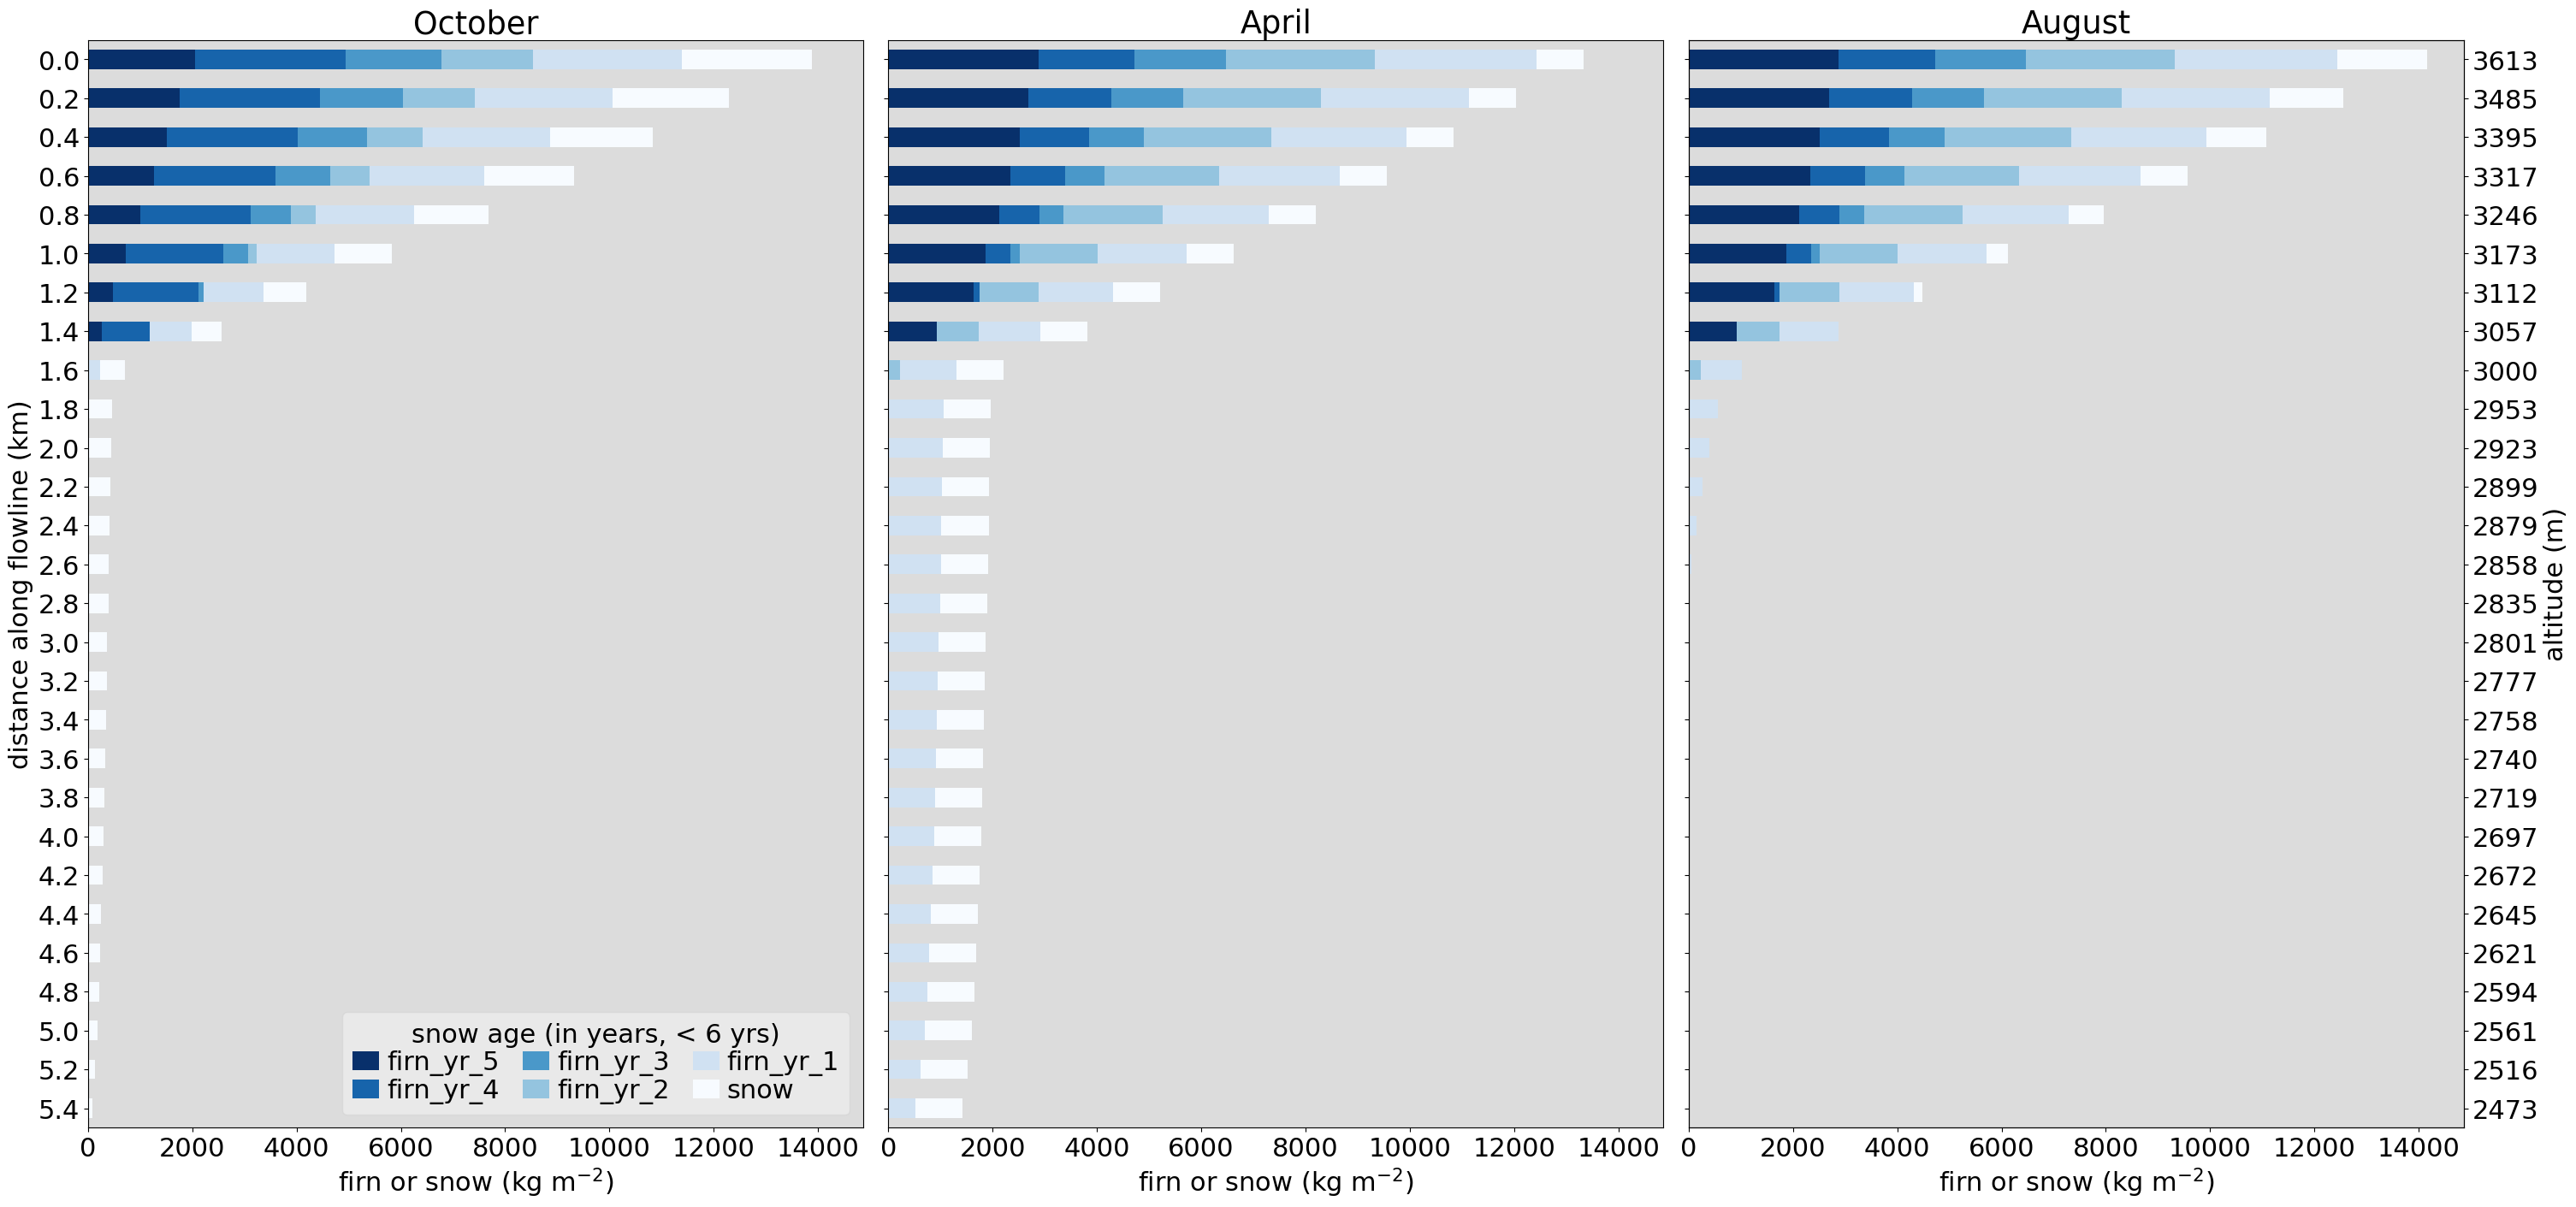

In [28]:

name = '0_5_a'
fig, axs = plt.subplots(1,3, figsize=(30,14), sharey=True, sharex=True,constrained_layout=True)
year = 2001
for j,m in enumerate([10,4,8]):
    
    ax = axs[j]
    ax.set_facecolor('gainsboro')
    if m == 10:
        year = 2000
    else:
        year = 2001

    floatyr = utils.date_to_floatyear(year, m)
    
    sns_pd_bucket_sel = bucket[name][floatyr].copy()
    sns_pd_bucket_sel['altitude (m)'] = h.round(1)
    sns_pd_bucket_sel = sns_pd_bucket_sel[sns_pd_bucket_sel.columns[::-1]]
    
    sns_pd_bucket_sel.index = bucket[name][floatyr].index #sns_pd_bucket_sel['altitude (m)']
    # only plot every second altitude band !!! 
    sns_pd_bucket_sel = sns_pd_bucket_sel.iloc[::2]
    pd_pivot = sns_pd_bucket_sel[sns_pd_bucket_sel.columns[2:]]
    pd_pivot.index = pd_pivot.index/1000
    pd_pivot = pd_pivot.sort_index(ascending=False)
    #sns_pd_bucket_sel['altitude (m)'] = sns_pd_bucket_sel.altitude.round(1)
    #pd_pivot.sum(axis=1).plot.barh(
    #         x=pd_pivot.index,
    #         color='white', alpha= 0.1, ax=ax)

    pd_pivot.plot.barh(stacked=True, ax= ax,
                       #yticks = pd_pivot.index[::10],
                       colormap='Blues_r', #'winter'#, secondary_y=sns_pd_bucket_sel['altitude (m)'].values
                       )
    #ax.plot(pd_pivot.sum(axis=1).values, pd_pivot.index, 'o', color='grey', alpha= 0.5)
    #ax.set_yticks(pd_pivot.index[::10], labels = pd_pivot.index[::10]);
    han, lab = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    if j == 0:
        #ax.legend(handles = [han[k-1] for k in [12, 24, 36, 48, 60, 72]],
        #          labels = [lab[k-1] for k in [12, 24, 36, 48, 60, 72]],
        #          title='snow age\n(<72 months)',  loc = 4, framealpha = 0.4, ncol=6);
        ax.legend(handles = han, #[k-1] for k in [12, 24, 36, 48, 60, 72]],
                  labels = lab, #[k-1] for k in [12, 24, 36, 48, 60, 72]],
                  title='snow age (in years, < 6 yrs)',  loc = 4, framealpha = 0.4, ncol=3,
                  labelspacing=0.1, handlelength=1, handletextpad=0.3, columnspacing=0.9);
        ax.set_ylabel('distance along flowline (km)')
    #if j == 2:
    #    ax2 = ax.twinx() 
    #    #ax2.bar(np.full(len(h), 0), h, color = 'blue')  
    #    ax2.bar(np.full(len(h), 0), h/1000, color = 'blue', alpha = 0)  
    #    ax2.set_ylabel('altitude (km)')
    #    ax2.set_ylim([h.min(), h.max()])

    #    ax.secondary_yaxis(bucket[name][floatyr].index[::2])
    ax.set_xlabel(r'firn or snow (kg m$^{-2}$)')
    if m== 10:
        ax.set_title(f'October')
    elif m==4:
        ax.set_title(f'April')
    elif m==8:
        ax.set_title(f'August')
    #ax.secondary_yaxis('right', bucket[name][floatyr].index[::2].values)
    if j == 2:
        ax2 = ax.twinx()
        pd_pivot.plot.barh(stacked=True, ax= ax2,
                   #yticks = pd_pivot.index[::10],
                   colormap='Blues_r', alpha = 0,#'winter'#, secondary_y=sns_pd_bucket_sel['altitude (m)'].values
                   )
        ax2.set_yticklabels(h[::2].round(0).astype(int)[::-1])
        ax2.set_ylabel('altitude (m)')
        ax2.get_legend().remove()


In [31]:
mb_grad_winter.keys()

dict_keys(['0_5_m_neg_exp_tau1yr', '0_5_m_neg_exp', '0_5_m', '0_5_a_neg_exp_tau1yr', '0_5_a_neg_exp', '0_5_a', '1_a'])

In [35]:
label_dict['0_5_a'] = r'linear $d_f$ change'+'\nannual update'

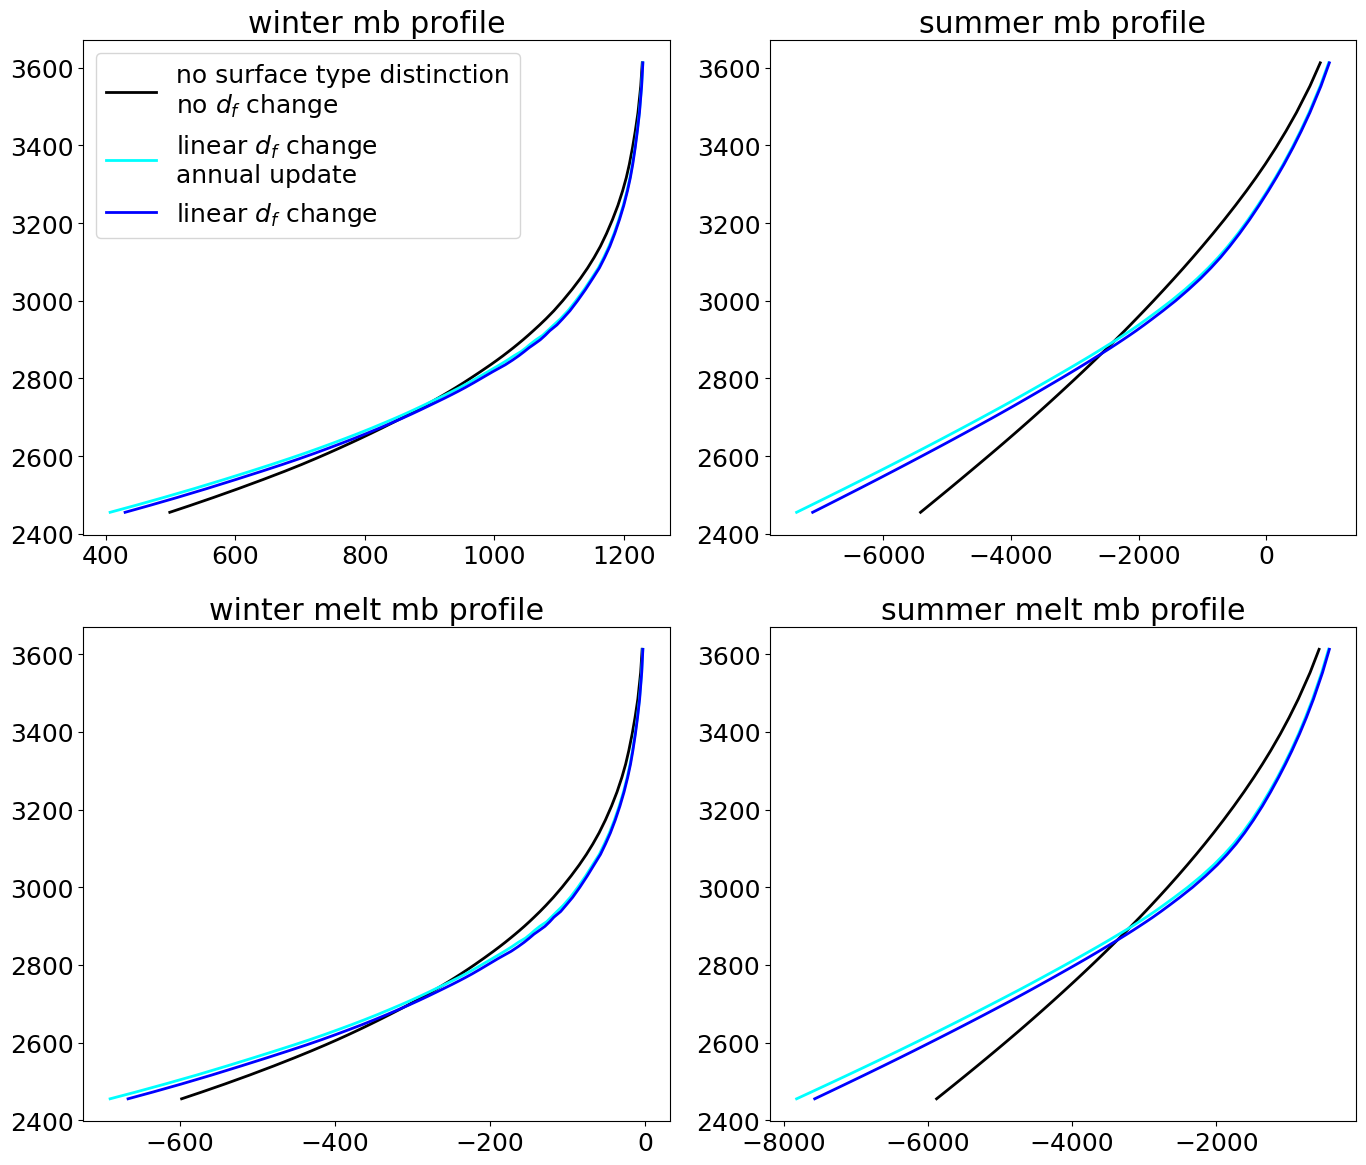

In [38]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(14,12))
plt.subplot(221)
plt.title('winter mb profile')
name = '1_a'
plt.plot(mb_grad_winter[name][0], mb_grad_winter[name][1], color = 'black', lw = lw, label=label_dict[name])
name = '0_5_a'
plt.plot(mb_grad_winter[name][0], mb_grad_winter[name][1], color = 'cyan', lw = lw, label=label_dict[name])
name = '0_5_m' #_tau1yr'
plt.plot(mb_grad_winter[name][0], mb_grad_winter[name][1], color = 'blue', lw = lw, label=label_dict[name])
plt.legend()
ax=plt.gca()
plt.subplot(222, sharey=ax)
plt.title('summer mb profile')
name = '1_a'
plt.plot(mb_grad_summer[name][0], mb_grad_summer[name][1], color = 'black', lw = lw)
name = '0_5_a'
plt.plot(mb_grad_summer[name][0], mb_grad_summer[name][1], color = 'cyan', lw = lw)
name = '0_5_m'
plt.plot(mb_grad_summer[name][0], mb_grad_summer[name][1], color = 'blue', lw = lw)
plt.tight_layout()

plt.subplot(223)
plt.title('winter melt mb profile')
name = '1_a'
plt.plot(mb_grad_winter_melt[name][0], mb_grad_winter_melt[name][1], color = 'black', lw = lw)
name = '0_5_a'
plt.plot(mb_grad_winter_melt[name][0], mb_grad_winter_melt[name][1], color = 'cyan', lw = lw)
name = '0_5_m'
plt.plot(mb_grad_winter_melt[name][0], mb_grad_winter_melt[name][1], color = 'blue', lw = lw)
ax=plt.gca()
plt.subplot(224, sharey=ax)
plt.title('summer melt mb profile')
name = '1_a'
plt.plot(mb_grad_summer_melt[name][0], mb_grad_summer_melt[name][1], color = 'black', lw = lw)
name = '0_5_a'
plt.plot(mb_grad_summer_melt[name][0], mb_grad_summer_melt[name][1], color = 'cyan', lw = lw)
name = '0_5_m' #_tau1yr'
plt.plot(mb_grad_summer_melt[name][0], mb_grad_summer_melt[name][1], color = 'blue', lw = lw)
plt.tight_layout()